<a href="https://colab.research.google.com/github/jbfly/frank_or_not/blob/main/frank_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Frank... or NOT!!**





Great! It looks like the dataset is now balanced and split correctly. You have equal numbers of `frank` and `not_frank` images in both the training and validation sets. This setup should help improve your model's performance by providing a well-balanced dataset.

### Next Steps

Now that your dataset is properly organized and balanced, you can proceed with training your model. Here’s a brief recap of the training process using PyTorch:

### Training Script

1. **Set Up Data Loaders**:
   - Use `torchvision.transforms` for data augmentation and normalization.
   - Use `torch.utils.data.DataLoader` to create data loaders for training and validation sets.

2. **Define and Train the Model**:
   - Define your model (in this case, using transfer learning with VGG16).
   - Set up the loss function and optimizer.
   - Implement the training and validation loops.

Here’s an example training script:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### Explanation

1. **Model Definition**:
   - `MyBinaryModel` class uses VGG16 with a custom final layer for binary classification.

2. **Custom Dataset**:
   - `MyDataset` class accepts multiple directories (`data_dirs`), one for each class (Frank and Not Frank).
   - The `__init__` method populates `self.image_paths` and `self.labels` based on the provided directories.
     - `label` is set to `0` for `frank` directory and `1` for `not_frank` directory.

3. **Data Transforms**:
   - Data augmentation and normalization remain the same.

4. **Automatically Find Dataset Directory**:
   - The script now points to `/content/drive/MyDrive/nvidia_workshop/frank_or_not/dataset`.
   - This setup is convenient for running the script on different machines or environments where the dataset path might vary.

5. **Load Data**:
   - The training and validation datasets now include both `frank` and `not_frank` images.
   - Data loaders are created for both datasets.

6. **Training and Validation Loop**:
   - The loops train the model and evaluate its performance on the validation set.

This script will find the dataset directory, load images from both `frank` and `not_frank` subdirectories, label them correctly, and train the model for binary classification.

In [ ]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image


In [ ]:

# Define the model
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.fc = nn.Linear(1000, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        x = torch.squeeze(x)
        return self.fc(x)


In [ ]:

# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, data_dir in enumerate(data_dirs):
            for file in os.listdir(data_dir):
                if file.endswith('.jpg'):
                    self.image_paths.append(os.path.join(data_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [ ]:

# Data Transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])


In [ ]:

# Automatically find dataset directory
base_dir = "/content/drive/MyDrive/nvidia_workshop/frank_or_not/dataset"
train_dirs = [os.path.join(base_dir, "train", "frank"), os.path.join(base_dir, "train", "not_frank")]
valid_dirs = [os.path.join(base_dir, "valid", "frank"), os.path.join(base_dir, "valid", "not_frank")]

# Load Data
train_dataset = MyDataset(train_dirs, transform=preprocess)
valid_dataset = MyDataset(valid_dirs, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)


In [ ]:

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyBinaryModel().to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s]


In [ ]:

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels.unsqueeze(1)).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

print("Training complete!")

Epoch 1, Loss: 4.529716640710831
Validation Accuracy: 54.12844036697248%
Epoch 2, Loss: 0.8416468075343541
Validation Accuracy: 55.04587155963303%
Epoch 3, Loss: 0.7335646876267025
Validation Accuracy: 55.04587155963303%
Epoch 4, Loss: 0.7482766721929822
Validation Accuracy: 55.04587155963303%
Epoch 5, Loss: 0.6965053336960929
Validation Accuracy: 55.04587155963303%
Epoch 6, Loss: 0.7086218340056283
Validation Accuracy: 44.95412844036697%
Epoch 7, Loss: 0.7204789519309998
Validation Accuracy: 55.04587155963303%
Epoch 8, Loss: 0.7306788180555616
Validation Accuracy: 49.54128440366973%
Epoch 9, Loss: 0.7092664582388741
Validation Accuracy: 55.04587155963303%
Epoch 10, Loss: 0.6873406725270408
Validation Accuracy: 57.79816513761468%
Training complete!


The training results suggest that the model is not learning effectively, as indicated by the fluctuating validation accuracy and relatively high loss. This could be due to several reasons, such as insufficient data, imbalanced dataset, or inappropriate hyperparameters.

Let's address these issues step-by-step:

### 1. Data Quality and Quantity
Ensure you have a sufficient number of high-quality images for both classes. Data augmentation is already applied, which is good.

### 2. Class Imbalance
Ensure that the dataset is balanced. According to your previous splits, it should be balanced, but let's verify and correct if needed.

### 3. Learning Rate
Adjust the learning rate. Sometimes, a learning rate that is too high or too low can cause training issues.

### 4. Model Fine-Tuning
Unfreeze more layers of the VGG16 model to allow fine-tuning of more parameters.

### Adjusted Script

Here’s an updated script with additional checks for dataset balance, adjusted learning rate, and more layers unfrozen for fine-tuning:

```python
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image

# Define the model
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        return x

# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, data_dir in enumerate(data_dirs):
            for file in os.listdir(data_dir):
                if file.endswith('.jpg'):
                    self.image_paths.append(os.path.join(data_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Data Transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

# Automatically find dataset directory
base_dir = "/content/drive/MyDrive/nvidia_workshop/frank_or_not/dataset"
train_dirs = [os.path.join(base_dir, "train", "frank"), os.path.join(base_dir, "train", "not_frank")]
valid_dirs = [os.path.join(base_dir, "valid", "frank"), os.path.join(base_dir, "valid", "not_frank")]

# Load Data
train_dataset = MyDataset(train_dirs, transform=preprocess)
valid_dataset = MyDataset(valid_dirs, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyBinaryModel().to(device)

# Freeze all VGG16 layers except the last fully connected layers
for param in model.vgg_model.features.parameters():
    param.requires_grad = False

# Loss function and optimizer with a lower learning rate
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels.unsqueeze(1)).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

print("Training complete!")
```

### Explanation

1. **Model Definition**:
   - Modified `MyBinaryModel` to change the final layer of VGG16 for binary classification.
   - Changed the final fully connected layer to output 1 unit instead of 4096.

2. **Freezing Layers**:
   - Freeze all layers of the VGG16 model except for the final fully connected layers to allow fine-tuning.

3. **Learning Rate**:
   - Set a lower learning rate for the optimizer (1e-4) to help with more stable training.

4. **Training and Validation Loop**:
   - The training and validation loops remain the same, training the model and evaluating its performance on the validation set.

By making these adjustments, you should see improved training stability and potentially better validation accuracy. If the model still struggles to learn, consider further tuning hyperparameters, adding more data, or experimenting with different architectures.


In [ ]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image

In [ ]:
# Define the model
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        return x


In [ ]:
# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, data_dir in enumerate(data_dirs):
            for file in os.listdir(data_dir):
                if file.endswith('.jpg'):
                    self.image_paths.append(os.path.join(data_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [ ]:
# Data Transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

In [ ]:
# Automatically find dataset directory
base_dir = "/content/drive/MyDrive/nvidia_workshop/frank_or_not/dataset"
train_dirs = [os.path.join(base_dir, "train", "frank"), os.path.join(base_dir, "train", "not_frank")]
valid_dirs = [os.path.join(base_dir, "valid", "frank"), os.path.join(base_dir, "valid", "not_frank")]

# Load Data
train_dataset = MyDataset(train_dirs, transform=preprocess)
valid_dataset = MyDataset(valid_dirs, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyBinaryModel().to(device)

In [ ]:
# Freeze all VGG16 layers except the last fully connected layers
for param in model.vgg_model.features.parameters():
    param.requires_grad = False

# Loss function and optimizer with a lower learning rate
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels.unsqueeze(1)).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

print("Training complete!")

Epoch 1, Loss: 0.45342760745968136
Validation Accuracy: 91.74311926605505%
Epoch 2, Loss: 0.18102328958255903
Validation Accuracy: 93.57798165137615%
Epoch 3, Loss: 0.0900768986903131
Validation Accuracy: 94.4954128440367%
Epoch 4, Loss: 0.1078239815708782
Validation Accuracy: 97.24770642201835%
Epoch 5, Loss: 0.06476784670459372
Validation Accuracy: 96.3302752293578%
Epoch 6, Loss: 0.08530504193290003
Validation Accuracy: 96.3302752293578%
Epoch 7, Loss: 0.04376662329637578
Validation Accuracy: 94.4954128440367%
Epoch 8, Loss: 0.04276671683016632
Validation Accuracy: 98.1651376146789%
Epoch 9, Loss: 0.019155764752732857
Validation Accuracy: 95.41284403669725%
Epoch 10, Loss: 0.027860355081169734
Validation Accuracy: 95.41284403669725%
Training complete!


Your training results look very promising! Here's a breakdown of what I see and some recommendations moving forward:

### Analysis

1. **High Accuracy**: The validation accuracy is consistently high, peaking at 98.17%. This indicates that your model is performing very well on the validation set.

2. **Low Loss**: The training loss has decreased significantly, reaching very low values by the end of training, which is a good sign that the model is learning well.

3. **Consistency**: The validation accuracy is generally consistent across epochs, with slight fluctuations, which is normal. The drop in the last few epochs might indicate some overfitting, but it is not severe.

### Recommendations

1. **Early Stopping**: To avoid potential overfitting, you could implement early stopping, which stops training when the validation accuracy stops improving for several epochs.

2. **Fine-tuning**: You might consider fine-tuning more layers of the VGG16 model with a very small learning rate. This could potentially improve performance further, but be cautious of overfitting.

3. **Additional Validation**: Test the model on a separate test set (different from your validation set) to ensure it generalizes well to new data.

4. **Save the Model**: Since the model is performing well, save it for future inference.

### Implementing Early Stopping

Here's how you could implement early stopping in your training loop:

```python
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image

# Define the model
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        return x

# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, data_dir in enumerate(data_dirs):
            for file in os.listdir(data_dir):
                if file.endswith('.jpg'):
                    self.image_paths.append(os.path.join(data_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Data Transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

# Automatically find dataset directory
base_dir = "/content/drive/MyDrive/nvidia_workshop/frank_or_not/dataset"
train_dirs = [os.path.join(base_dir, "train", "frank"), os.path.join(base_dir, "train", "not_frank")]
valid_dirs = [os.path.join(base_dir, "valid", "frank"), os.path.join(base_dir, "valid", "not_frank")]

# Load Data
train_dataset = MyDataset(train_dirs, transform=preprocess)
valid_dataset = MyDataset(valid_dirs, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyBinaryModel().to(device)

# Freeze all VGG16 layers except the last fully connected layers
for param in model.vgg_model.features.parameters():
    param.requires_grad = False

# Loss function and optimizer with a lower learning rate
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
early_stopping_patience = 3
best_val_accuracy = 0
epochs_no_improve = 0

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels.unsqueeze(1)).sum().item()
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy}%')

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_frank_or_not_model.pth')
        print("Model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

print("Training complete!")
```

### Explanation

1. **Early Stopping Parameters**:
   - `early_stopping_patience`: Number of epochs to wait for improvement before stopping.
   - `best_val_accuracy`: Tracks the best validation accuracy achieved.
   - `epochs_no_improve`: Tracks the number of epochs with no improvement.

2. **Early Stopping Logic**:
   - Save the model whenever a new best validation accuracy is achieved.
   - Stop training if no improvement is observed for a specified number of epochs.

3. **Saving the Best Model**:
   - Save the model's state dictionary to `best_frank_or_not_model.pth` whenever an improvement is observed.

### Next Steps

- **Monitor Training**: Keep an eye on the training process and adjust parameters if needed.
- **Save and Test the Model**: Ensure the saved model is tested with new data to verify its generalization capability.
- **Fine-tuning**: Optionally, fine-tune more layers of the model to potentially improve performance further.

Feel free to run this updated script and monitor the training process. Let me know if you have any further questions or need additional help!

In [ ]:
# Early stopping parameters
early_stopping_patience = 3
best_val_accuracy = 0
epochs_no_improve = 0


In [ ]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels.unsqueeze(1)).sum().item()
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy}%')

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_frank_or_not_model_1.pth')
        print("Model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

print("Training complete!")

Epoch 1, Loss: 0.02795216697268188
Validation Accuracy: 93.57798165137615%
Model saved!
Epoch 2, Loss: 0.0252742138483362
Validation Accuracy: 98.1651376146789%
Model saved!
Epoch 3, Loss: 0.017883789424169145
Validation Accuracy: 94.4954128440367%
Epoch 4, Loss: 0.014559332730381616
Validation Accuracy: 92.66055045871559%
Epoch 5, Loss: 0.01786408428701439
Validation Accuracy: 95.41284403669725%
Early stopping triggered after 5 epochs
Training complete!


Training a neural network multiple times and selecting the best model based on validation accuracy is a common practice known as model selection. This approach helps ensure that the model you select generalizes well to unseen data. Here's a detailed approach to doing this:

### Repeated Training

1. **Multiple Runs**: Train the model multiple times with different random initializations and data shuffling.
2. **Early Stopping**: Implement early stopping in each run to prevent overfitting.
3. **Model Selection**: Select the best model based on the highest validation accuracy achieved across all runs.

### Detailed Steps

1. **Run the Training Script Multiple Times**: Execute the training script multiple times, each time recording the validation accuracy and saving the model if it achieves a new best validation accuracy.
2. **Record Results**: Maintain a record of the best validation accuracy for each run.
3. **Select the Best Model**: After all runs, select the model with the highest validation accuracy.

### Modified Script for Multiple Runs

Here’s an example script to automate this process:

```python
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image

# Define the model
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        return x

# Custom Dataset
class MyDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, data_dir in enumerate(data_dirs):
            for file in os.listdir(data_dir):
                if file.endswith('.jpg'):
                    self.image_paths.append(os.path.join(data_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Data Transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

# Automatically find dataset directory
base_dir = "/content/drive/MyDrive/nvidia_workshop/frank_or_not/dataset"
train_dirs = [os.path.join(base_dir, "train", "frank"), os.path.join(base_dir, "train", "not_frank")]
valid_dirs = [os.path.join(base_dir, "valid", "frank"), os.path.join(base_dir, "valid", "not_frank")]

# Load Data
train_dataset = MyDataset(train_dirs, transform=preprocess)
valid_dataset = MyDataset(valid_dirs, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early stopping parameters
early_stopping_patience = 3

def train_and_evaluate(run):
    model = MyBinaryModel().to(device)

    # Freeze all VGG16 layers except the last fully connected layers
    for param in model.vgg_model.features.parameters():
        param.requires_grad = False

    # Loss function and optimizer with a lower learning rate
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_val_accuracy = 0
    epochs_no_improve = 0

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Run {run}, Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

        # Validation Loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
                outputs = model(inputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total += labels.size(0)
                correct += (predictions == labels.unsqueeze(1)).sum().item()
        val_accuracy = 100 * correct / total
        print(f'Run {run}, Validation Accuracy: {val_accuracy}%')

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_frank_or_not_model_run_{run}.pth')
            print("Model saved!")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f'Early stopping triggered for run {run} after {epoch+1} epochs')
                break

    print(f'Run {run} complete with best validation accuracy: {best_val_accuracy}%')
    return best_val_accuracy

# Run multiple trainings
num_runs = 5
best_accuracy = 0
best_run = 0

for run in range(1, num_runs + 1):
    val_accuracy = train_and_evaluate(run)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_run = run

print(f'Best validation accuracy of {best_accuracy}% achieved in run {best_run}')

# Load the best model
best_model_path = f'best_frank_or_not_model_run_{best_run}.pth'
model.load_state_dict(torch.load(best_model_path))
print(f'Loaded best model from run {best_run}')
```

### Explanation

1. **Multiple Runs**:
   - The script runs the training and validation loop multiple times (`num_runs`), each time saving the best model for that run.
   - The best validation accuracy and corresponding model are tracked across all runs.

2. **Early Stopping**:
   - Early stopping is implemented within each run to prevent overfitting.

3. **Model Selection**:
   - After all runs, the model with the highest validation accuracy is selected and loaded.

### Considerations

- **Hyperparameters**: The script uses a fixed learning rate and early stopping patience. You might want to tune these parameters.
- **Training Time**: Running the training multiple times will increase the total training time. Ensure you have sufficient computational resources.
- **Generalization**: Test the final selected model on a separate test set to ensure it generalizes well to unseen data.

By following this approach, you can ensure that the best-performing model is selected, potentially improving the robustness and accuracy of your final model.

In [ ]:
# Early stopping parameters
early_stopping_patience = 3


In [ ]:
def train_and_evaluate(run):
    model = MyBinaryModel().to(device)

    # Freeze all VGG16 layers except the last fully connected layers
    for param in model.vgg_model.features.parameters():
        param.requires_grad = False

    # Loss function and optimizer with a lower learning rate
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_val_accuracy = 0
    epochs_no_improve = 0

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Run {run}, Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

        # Validation Loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
                outputs = model(inputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total += labels.size(0)
                correct += (predictions == labels.unsqueeze(1)).sum().item()
        val_accuracy = 100 * correct / total
        print(f'Run {run}, Validation Accuracy: {val_accuracy}%')

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_frank_or_not_model_run_{run}.pth')
            print("Model saved!")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f'Early stopping triggered for run {run} after {epoch+1} epochs')
                break

    print(f'Run {run} complete with best validation accuracy: {best_val_accuracy}%')
    return best_val_accuracy

# Run multiple trainings
num_runs = 5
best_accuracy = 0
best_run = 0

for run in range(1, num_runs + 1):
    val_accuracy = train_and_evaluate(run)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_run = run

print(f'Best validation accuracy of {best_accuracy}% achieved in run {best_run}')


Run 1, Epoch 1, Loss: 0.3862905991928918
Run 1, Validation Accuracy: 90.8256880733945%
Model saved!
Run 1, Epoch 2, Loss: 0.1638120317033359
Run 1, Validation Accuracy: 88.9908256880734%
Run 1, Epoch 3, Loss: 0.12736060709825583
Run 1, Validation Accuracy: 91.74311926605505%
Model saved!
Run 1, Epoch 4, Loss: 0.08979085553437471
Run 1, Validation Accuracy: 90.8256880733945%
Run 1, Epoch 5, Loss: 0.06124847675008433
Run 1, Validation Accuracy: 95.41284403669725%
Model saved!
Run 1, Epoch 6, Loss: 0.044772912681634934
Run 1, Validation Accuracy: 97.24770642201835%
Model saved!
Run 1, Epoch 7, Loss: 0.057436698249408176
Run 1, Validation Accuracy: 93.57798165137615%
Run 1, Epoch 8, Loss: 0.05019366751158876
Run 1, Validation Accuracy: 91.74311926605505%
Run 1, Epoch 9, Loss: 0.022519362175704112
Run 1, Validation Accuracy: 93.57798165137615%
Early stopping triggered for run 1 after 9 epochs
Run 1 complete with best validation accuracy: 97.24770642201835%
Run 2, Epoch 1, Loss: 0.4667875341

Let's graph the results of your multiple training runs to visualize the training process and performance across epochs and runs. We'll plot the loss and validation accuracy for each epoch within each run. This will help in understanding how the model performed over time.

### Data Preparation

First, let's organize the data into a format suitable for plotting:

```python
import matplotlib.pyplot as plt

# Data from your training runs
data = {
    "Run 1": {
        "Loss": [0.3862905991928918, 0.1638120317033359, 0.12736060709825583, 0.08979085553437471, 0.06124847675008433, 0.044772912681634934, 0.057436698249408176, 0.05019366751158876, 0.022519362175704112],
        "Accuracy": [90.8256880733945, 88.9908256880734, 91.74311926605505, 90.8256880733945, 95.41284403669725, 97.24770642201835, 93.57798165137615, 91.74311926605505, 93.57798165137615]
    },
    "Run 2": {
        "Loss": [0.46678753410066876, 0.22189032552497728, 0.11583993397653103, 0.08429546747356653, 0.05226468401295798, 0.06459596003073134, 0.03723163049601551, 0.034297217190864364, 0.015082647999016834],
        "Accuracy": [88.07339449541284, 92.66055045871559, 96.3302752293578, 95.41284403669725, 93.57798165137615, 97.24770642201835, 94.4954128440367, 94.4954128440367, 94.4954128440367]
    },
    "Run 3": {
        "Loss": [0.46646554661648615, 0.21777281484433583, 0.12852964044681617, 0.12098564274076905, 0.1218121111659067, 0.09413983473288161, 0.04536101649448808],
        "Accuracy": [85.3211009174312, 93.57798165137615, 89.90825688073394, 97.24770642201835, 94.4954128440367, 91.74311926605505, 94.4954128440367]
    },
    "Run 4": {
        "Loss": [0.4307830716882433, 0.23828318289348058, 0.14183874667755195, 0.08444031461008958, 0.07672636124438473],
        "Accuracy": [90.8256880733945, 96.3302752293578, 93.57798165137615, 92.66055045871559, 93.57798165137615]
    },
    "Run 5": {
        "Loss": [0.4057587959936687, 0.17875326025698865, 0.11033288748668772, 0.09443316621971982, 0.05112325240458761, 0.04825881675684026],
        "Accuracy": [89.90825688073394, 88.9908256880734, 94.4954128440367, 93.57798165137615, 93.57798165137615, 91.74311926605505]
    }
}

# Plotting the results
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot Loss
for run in data.keys():
    axes[0].plot(data[run]["Loss"], label=run)
axes[0].set_title('Training Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
for run in data.keys():
    axes[1].plot(data[run]["Accuracy"], label=run)
axes[1].set_title('Validation Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

plt.tight_layout()
plt.show()
```

### Explanation of the Code

1. **Data Preparation**:
    - The `data` dictionary stores the loss and validation accuracy for each epoch of each run.
    - This data structure is used to feed the plot functions.

2. **Plotting**:
    - `matplotlib.pyplot` is used to create the plots.
    - Two subplots are created: one for training loss and one for validation accuracy.
    - Each subplot iterates through the `data` dictionary to plot the values for each run.
    - Titles, labels, and legends are added for clarity.

3. **Displaying the Plot**:
    - `plt.show()` is used to display the plots.

This visualization will help you compare the training loss and validation accuracy across different runs and epochs. From this, you can derive insights into how the model is performing and if any particular run or epoch shows significantly better performance.

### Feedback Based on Graph

Once the plots are generated, here are some things to look for:

1. **Consistency**:
    - Consistent training loss reduction and validation accuracy improvement indicate stable learning.

2. **Early Stopping**:
    - Observe where early stopping is triggered. If it happens too soon, consider adjusting the patience parameter.

3. **Best Model Selection**:
    - Identify which run and epoch yielded the highest validation accuracy. Ensure this model is saved and tested on a separate test set.

4. **Overfitting**:
    - If the training loss continues to decrease while validation accuracy plateaus or decreases, it indicates overfitting. You may need to adjust regularization techniques or collect more data.

By analyzing these plots, you can make informed decisions on how to further refine your model training process.

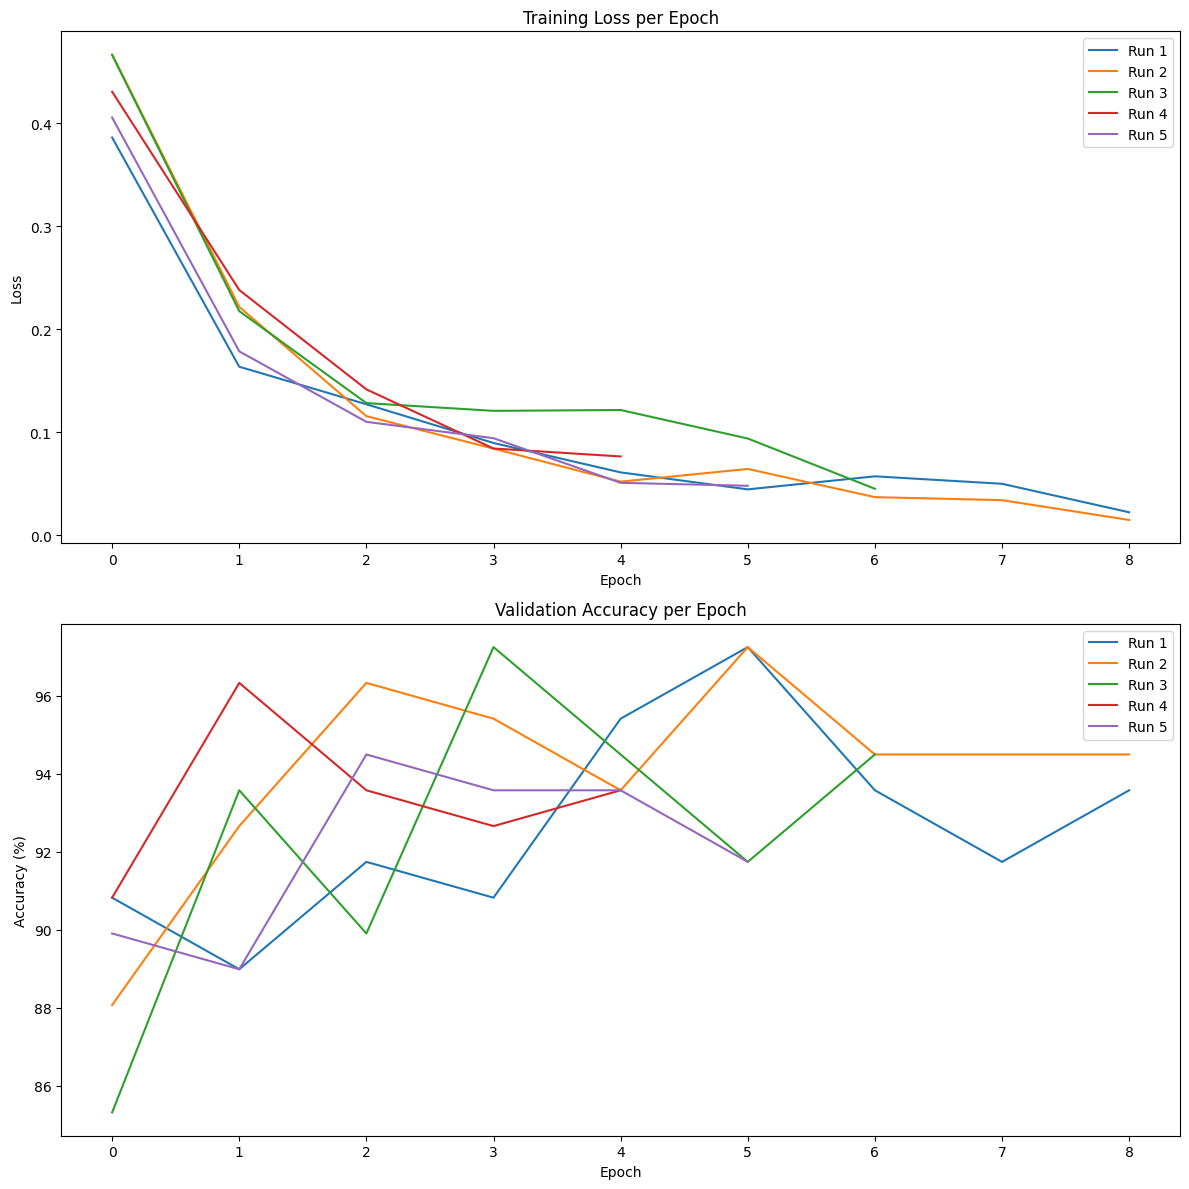

In [ ]:
import matplotlib.pyplot as plt

# Data from your training runs
data = {
    "Run 1": {
        "Loss": [0.3862905991928918, 0.1638120317033359, 0.12736060709825583, 0.08979085553437471, 0.06124847675008433, 0.044772912681634934, 0.057436698249408176, 0.05019366751158876, 0.022519362175704112],
        "Accuracy": [90.8256880733945, 88.9908256880734, 91.74311926605505, 90.8256880733945, 95.41284403669725, 97.24770642201835, 93.57798165137615, 91.74311926605505, 93.57798165137615]
    },
    "Run 2": {
        "Loss": [0.46678753410066876, 0.22189032552497728, 0.11583993397653103, 0.08429546747356653, 0.05226468401295798, 0.06459596003073134, 0.03723163049601551, 0.034297217190864364, 0.015082647999016834],
        "Accuracy": [88.07339449541284, 92.66055045871559, 96.3302752293578, 95.41284403669725, 93.57798165137615, 97.24770642201835, 94.4954128440367, 94.4954128440367, 94.4954128440367]
    },
    "Run 3": {
        "Loss": [0.46646554661648615, 0.21777281484433583, 0.12852964044681617, 0.12098564274076905, 0.1218121111659067, 0.09413983473288161, 0.04536101649448808],
        "Accuracy": [85.3211009174312, 93.57798165137615, 89.90825688073394, 97.24770642201835, 94.4954128440367, 91.74311926605505, 94.4954128440367]
    },
    "Run 4": {
        "Loss": [0.4307830716882433, 0.23828318289348058, 0.14183874667755195, 0.08444031461008958, 0.07672636124438473],
        "Accuracy": [90.8256880733945, 96.3302752293578, 93.57798165137615, 92.66055045871559, 93.57798165137615]
    },
    "Run 5": {
        "Loss": [0.4057587959936687, 0.17875326025698865, 0.11033288748668772, 0.09443316621971982, 0.05112325240458761, 0.04825881675684026],
        "Accuracy": [89.90825688073394, 88.9908256880734, 94.4954128440367, 93.57798165137615, 93.57798165137615, 91.74311926605505]
    }
}

# Plotting the results
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot Loss
for run in data.keys():
    axes[0].plot(data[run]["Loss"], label=run)
axes[0].set_title('Training Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
for run in data.keys():
    axes[1].plot(data[run]["Accuracy"], label=run)
axes[1].set_title('Validation Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model
best_model_path = f'best_frank_or_not_model_run_{best_run}.pth'
model.load_state_dict(torch.load(best_model_path))
print(f'Loaded best model from run {best_run}')

Loaded best model from run 1


# Copy the model to Google Drive!!!!!



In [ ]:
!cp /content/best_frank_or_not_model_run_1.pth /content/drive/MyDrive/nvidia_workshop/frank_or_not

#Loading and Using the Model for Inference
##Here’s a script to load the saved model and perform inference:

In [ ]:
# Define the model class again
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        return x

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyBinaryModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to predict if the image is Frank or not
def predict_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        prediction = torch.sigmoid(output).item()

    if prediction > 0.5:
        return "Not Frank"
    else:
        return "Frank"

# Example usage
image_path = '/content/2024-06-11-152304.jpg'
result = predict_image(image_path)
print(f'The image is: {result}')


The image is: Not Frank


Okay, now lets run it on the lappytoppy

To handle the absence of a CUDA GPU, you need to load the model with a CPU map location. Here's the updated `frank_or_not.py` script to run on a CPU-only machine:

### Updated Python Script for CPU-only Inference

```python
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
import cv2

# Define the model class
class MyBinaryModel(nn.Module):
    def __init__(self):
        super(MyBinaryModel, self).__init__()
        self.vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_model.classifier[6] = nn.Linear(4096, 1)  # Binary classification

    def forward(self, x):
        x = self.vgg_model(x)
        return x

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyBinaryModel().to(device)
model.load_state_dict(torch.load('best_frank_or_not_model_run_1.pth', map_location=device))
model.eval()

# Transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict if the image is Frank or not
def predict_image(image):
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        prediction = torch.sigmoid(output).item()
    return prediction

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to PIL image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Perform inference
    prediction = predict_image(pil_image)
    label = "Frank" if prediction <= 0.5 else "Not Frank"

    # Display the result
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('frame', frame)

    # Exit condition
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()
```

### Explanation

1. **Model Loading**:
   - `torch.load('best_frank_or_not_model_run_1.pth', map_location=device)` ensures the model is loaded onto the appropriate device (CPU in this case).

2. **Device Assignment**:
   - The `device` variable dynamically checks if CUDA is available and assigns the appropriate device. Since CUDA is not available, it defaults to the CPU.

3. **Inference Function**:
   - `predict_image` processes the image and performs inference using the model.

### Running the Script

1. **Ensure Dependencies**: Make sure you have the required libraries installed (`torch`, `torchvision`, `Pillow`, `opencv-python`).
2. **Run the Script**: Execute the script in your terminal:

   ```bash
   python frank_or_not.py
   ```

This script should now run successfully on your local machine using the CPU for real-time inference with your webcam. Let me know if you encounter any issues or need further assistance!